In [1]:
import imgtda
from imgtda import standard_analysis as sa

import numpy as np
import pandas as pd
from scipy import misc
from skimage import morphology as morph
from skimage import measure

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation

%matplotlib inline

## Set Up Project

In [2]:
myproject = imgtda.Project

myproject['directory'] = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2015_09_16_fast'
myproject['bmp_format'] = 'g21flow/bmps/%06d.bmp'
myproject['pd_sub_format'] = 'g21flow/pd_sub/%06d.csv'
myproject['pd_sup_format'] = 'g21flow/pd_sup/%06d.csv'
myproject['additional_data'] = {'lyap_format':'g21per/bmps_abs_val/%05d.bmp',
                                'delta':10}


## Utility Functions

In [3]:
def load_image_data(project, idx):
    
    im = imgtda.image.load_image_from_file(project['directory'] + "/" + (project['bmp_format'] % idx))
    im.load_sublevel_pd(project['directory'] + "/" + (project['pd_sub_format'] % idx))
    im.load_superlevel_pd(project['directory'] + "/" + (project['pd_sup_format'] % idx))
    return im

def load_lyap_data(project, idx):
    
    lyap = misc.imread(project['directory'] + "/" + (project['additional_data']['lyap_format'] % idx))
    return lyap

def cropping_region():

    c = np.zeros((421,421))
    centerx = 210
    centery = 210
    radius=200
    for i in range(c.shape[0]):
        for j in range(c.shape[1]):
            if ((i-centerx)**2 + (j-centery)**2 < radius**2):
                c[i,j] = 1
    c = c.astype(np.int)
    return c


def get_image_saddle_points(im, lowercutoff, uppercutoff, delta):
    
    # Generate persistent homology defect matrix
    ph_lower_saddles = im.persistence_diagrams['sub'].loc[(im.persistence_diagrams['sub']['dim']==0) & ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & (im.persistence_diagrams['sub']['death']>=lowercutoff) & (im.persistence_diagrams['sub']['death']<=127)][['d_x','d_y']]
    ph_lower_saddles.columns = ['col', 'row']
    ph_tmp = im.persistence_diagrams['sub'].loc[(im.persistence_diagrams['sub']['dim']==1) & ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & (im.persistence_diagrams['sub']['birth']>=lowercutoff) & (im.persistence_diagrams['sub']['birth']<=127)][['b_x','b_y']]
    ph_tmp.columns = ['col', 'row']
    ph_lower_saddles = pd.concat([ph_lower_saddles, ph_tmp])

    ph_upper_saddles = im.persistence_diagrams['sup'].loc[(im.persistence_diagrams['sup']['dim']==0) & ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & (im.persistence_diagrams['sup']['death']>=127) & (im.persistence_diagrams['sup']['death']<=uppercutoff)][['d_x','d_y']]
    ph_upper_saddles.columns = ['col', 'row']
    ph_tmp = im.persistence_diagrams['sup'].loc[(im.persistence_diagrams['sup']['dim']==1) & ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & (im.persistence_diagrams['sup']['birth']>=127) & (im.persistence_diagrams['sup']['birth']<=uppercutoff)][['b_x','b_y']]
    ph_tmp.columns = ['col', 'row']
    ph_upper_saddles = pd.concat([ph_upper_saddles, ph_tmp])
    
    saddle_points = pd.concat([ph_lower_saddles, ph_upper_saddles])
    
    saddle_matrix = np.zeros(im.bmp.shape)
    saddle_matrix[saddle_points['row'], saddle_points['col']] = 1

    return saddle_matrix


def get_image_plumes(im, lowercutoff, uppercutoff, delta):
    
    # Generate persistent homology defect matrix
    ph_lower_plumes = im.persistence_diagrams['sub'].loc[(im.persistence_diagrams['sub']['dim']==1) & ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & (im.persistence_diagrams['sub']['death']<=uppercutoff) & (im.persistence_diagrams['sub']['birth']<=127)][['d_x','d_y']]
    ph_lower_plumes.columns = ['col', 'row']

    ph_upper_plumes = im.persistence_diagrams['sup'].loc[(im.persistence_diagrams['sup']['dim']==1) & ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & (im.persistence_diagrams['sup']['birth']>=127) & (im.persistence_diagrams['sup']['death']>=lowercutoff)][['d_x','d_y']]
    ph_upper_plumes.columns = ['col', 'row']
    
    plumes = pd.concat([ph_lower_plumes, ph_upper_plumes])
    
    plume_matrix = np.zeros(im.bmp.shape)
    plume_matrix[plumes['row'], plumes['col']] = 1

    return plume_matrix

def get_image_defects(idx, sigma, lowercutoff, uppercutoff, delta):

    im = load_image_data(myproject, idx)
    
    im.generate_orientation_field(sigma,1)
    im.saddle_points = get_image_saddle_points(im, lowercutoff, uppercutoff, delta)
    im.plumes = get_image_plumes(im, lowercutoff, uppercutoff, delta)

    return im


## Preprocess data for animation

### Functions for processing

In [24]:
def get_defect_regions(im, sigma, radius, wn_cutoff):
    
    topological_defects_dilated = morph.binary_dilation(im.orientation_fields[sigma].topological_defects, morph.disk(radius))
    saddle_points_dilated = morph.binary_dilation(im.saddle_points, morph.disk(radius))
    plumes_dilated = morph.binary_dilation(im.plumes, morph.disk(radius))
    all_ph_dilated = ((saddle_points_dilated+plumes_dilated)>0).astype(np.int)
    large_wn = (im.local_wavenumber >= wn_cutoff).astype(np.int)
    
    return (topological_defects_dilated, all_ph_dilated, large_wn)


### Processing code

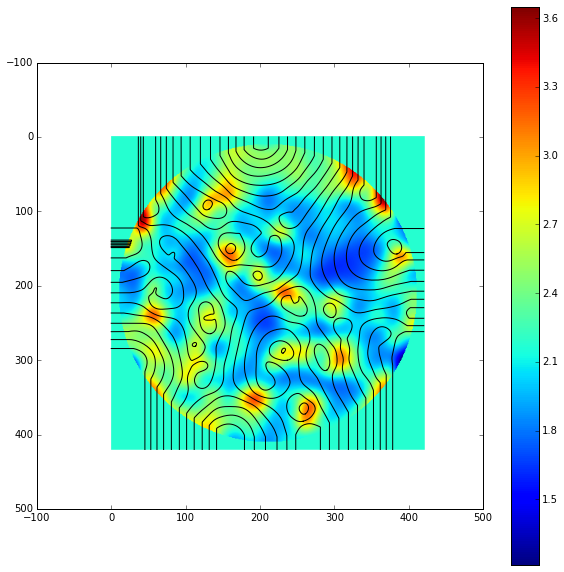

[[ 0.21819892  0.21819892  0.21819892 ...,  0.21819892  0.21819892
   0.21819892]
 [ 0.21819892  0.21819892  0.21819892 ...,  0.21819892  0.21819892
   0.21819892]
 [ 0.21819892  0.21819892  0.21819892 ...,  0.21819892  0.21819892
   0.21819892]
 ..., 
 [ 0.21819892  0.21819892  0.21819892 ...,  0.21819892  0.21819892
   0.21819892]
 [ 0.21819892  0.21819892  0.21819892 ...,  0.21819892  0.21819892
   0.21819892]
 [ 0.21819892  0.21819892  0.21819892 ...,  0.21819892  0.21819892
   0.21819892]]


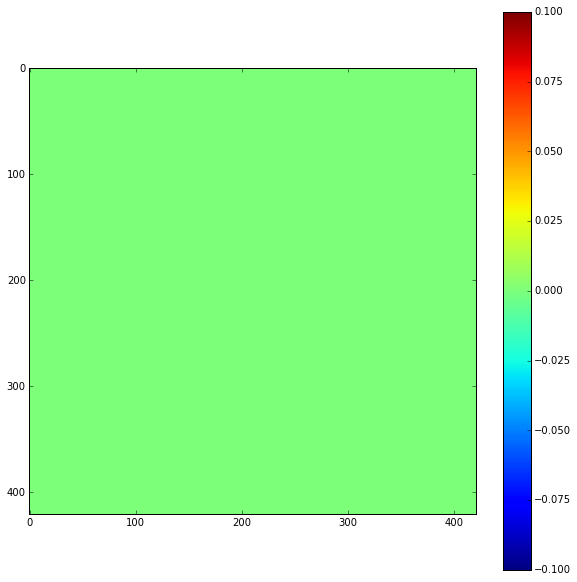

In [28]:
idx = 423

sigma = 3
radius = 10
lowercutoff = 45
uppercutoff = 200
delta = 10
wn_cutoff = 3.

plt.rcParams['figure.figsize'] = (10.0, 10.0) 

im = get_image_defects(idx, sigma, lowercutoff, uppercutoff, delta)

c = cropping_region()

im.local_wavenumber = sa.emb_wavenumber(im.bmp.astype(np.float), "difference", 10)*10.
im.local_wavenumber[c == 0] = np.median(im.local_wavenumber[c == 1])

contours = measure.find_contours(im.bmp, 127.)

plt.imshow(im.local_wavenumber*10.)
plt.colorbar()

for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1, color='black')
        
plt.show()



In [48]:
process_range = range(100, 1100)

sigma = 3
radius = 10
lowercutoff = 45
uppercutoff = 200
delta = 10
wn_cutoff = 3.

animation_data = {}

for idx in process_range:
    
    print idx
    
    im = get_image_defects(idx, sigma, lowercutoff, uppercutoff, delta)
    im.local_wavenumber = sa.emb_wavenumber(im.bmp.astype(np.float), "difference", 10)*10.
    
    lyap = load_lyap_data(myproject, idx)
    lyap = lyap.astype(np.float)/255.
    
    # Crop everything into a circular region
    c = cropping_region()
    im.bmp = np.multiply(im.bmp, c)
    im.orientation_fields[sigma].topological_defects = np.multiply(im.orientation_fields[sigma].topological_defects, c)
    im.saddle_points = np.multiply(im.saddle_points, c)
    im.plumes = np.multiply(im.plumes, c)
    lyap = np.multiply(lyap, c)
    im.local_wavenumber[c == 0] = np.median(im.local_wavenumber[c == 1])
    
    # Get the stuff to plot
    (td, ph, wn) = get_defect_regions(im, sigma, radius, wn_cutoff)
    contours = measure.find_contours(im.bmp, 127.)
    
    animation_data[idx] = {'td': td, 'ph': ph, 'wn': wn, 'contours': contours, 'lyap': lyap}


100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349


/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Animation code

In [49]:
def update_plot(ax, plot_data, lyap_cutoff):
    
    lyap_thresholded = np.ma.masked_where(plot_data['lyap'] >= lyap_cutoff, np.zeros(plot_data['lyap'].shape))

    colors_td = [(1, 1, 1), (0, 1, 1)] 
    cmap_name = 'w_td'
    cmap_td = LinearSegmentedColormap.from_list(
            cmap_name, colors_td, N=2)

    colors_ph = [(1, 1, 1), (1, 1, 0)] 
    cmap_name = 'w_ph'
    cmap_ph = LinearSegmentedColormap.from_list(
            cmap_name, colors_ph, N=2)

    colors_wn = [(1, 1, 1), (1, 0, 0)] 
    cmap_name = 'w_wn'
    cmap_wn = LinearSegmentedColormap.from_list(
            cmap_name, colors_wn, N=2)


    td_layer = ax.imshow(plot_data['td'], cmap=cmap_td, interpolation='nearest')
    ph_layer = ax.imshow(plot_data['ph'],alpha=.5, cmap=cmap_ph, interpolation='nearest')
    wn_layer = ax.imshow(plot_data['wn'],alpha=.3, cmap=cmap_wn, interpolation='nearest')
    lyap_layer = ax.imshow(lyap_thresholded,alpha=.5, cmap='gray', interpolation='nearest')

    plot_contours = []
    for n, contour in enumerate(plot_data['contours']):
        pc = ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='black')
        plot_contours.append(pc)

    return (td_layer, ph_layer, wn_layer, lyap_layer, plot_contours)
    

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349


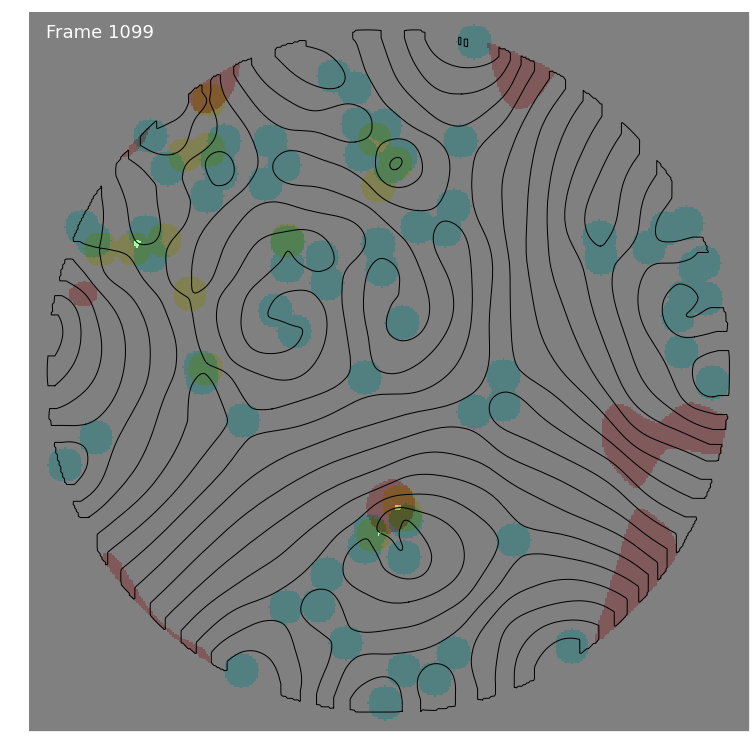

In [50]:
cutoff = 0.8

plt.rcParams['figure.figsize'] = (10.0, 10.0) 
fig = plt.figure();
ax = fig.add_subplot(111);
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None);
fig.gca().set_axis_off()

ax.set_xlim([0,im.bmp.shape[0]])
ax.set_ylim([im.bmp.shape[0], 0])

ims = []

for idx in process_range:
    
    print idx

    (td_layer, ph_layer, wn_layer, lyap_layer, plot_contours) = update_plot(ax, animation_data[idx], cutoff)
    
    txt_title = ax.annotate("Frame %d" % idx, (10,15), color='white', fontsize=18)
    ax.axis('off')
    ims.append([td_layer, ph_layer, wn_layer, lyap_layer, txt_title] + [contour[0] for contour in plot_contours])

writer = animation.FFMpegWriter(bitrate=1000, fps=10)
anim = animation.ArtistAnimation(fig, ims, blit=True, repeat_delay=350)
anim.save(myproject['directory'] + ('/lyap_wn_overlay_%0.1f_%d_%d.mp4' % (cutoff, process_range[0], process_range[-1])), writer=writer)